# Multimodal video search using CLIP and LanceDB
We used LanceDB to store frames every thirty seconds and the title of 13000+ videos, 5 random from each top category from the Youtube 8M dataset.
Then, we used the CLIP model to embed frames and titles together. With LanceDB, we can perform embedding, keyword, and SQL search on these videosjpg)

In [1]:
!pip install --quiet -U lancedb
!pip install --quiet gradio transformers torch torchvision duckdb
!pip install tantivy@git+https://github.com/quickwit-oss/tantivy-py#164adc87e1a033117001cf70e38c82a53014d985

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 9.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 6.2.0 requires pyarrow<13,>=2, but you have pyarrow 14.0.1 which is incompatible.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 14.0.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

## First run setup: Download data and pre-process


In [2]:
import duckdb
import lancedb

In [3]:
!wget https://vectordb-recipes.s3.us-west-2.amazonaws.com/multimodal_video_lance.tar.gz
!tar -xvf multimodal_video_lance.tar.gz
!mkdir -p data/video-lancedb
!mv multimodal_video.lance data/video-lancedb/

--2023-11-25 15:24:36--  https://vectordb-recipes.s3.us-west-2.amazonaws.com/multimodal_video_lance.tar.gz
Resolving vectordb-recipes.s3.us-west-2.amazonaws.com (vectordb-recipes.s3.us-west-2.amazonaws.com)... 52.92.178.186, 52.92.243.178, 3.5.85.15, ...
Connecting to vectordb-recipes.s3.us-west-2.amazonaws.com (vectordb-recipes.s3.us-west-2.amazonaws.com)|52.92.178.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239974228 (229M) [application/x-gzip]
Saving to: ‘multimodal_video_lance.tar.gz’

multimodal_video_la 100%[===================>] 228.86M  25.1MB/s    in 7.0s    

2023-11-25 15:24:43 (32.5 MB/s) - ‘multimodal_video_lance.tar.gz’ saved [239974228/239974228]

multimodal_video.lance/
multimodal_video.lance/.DS_Store
multimodal_video.lance/_versions/
multimodal_video.lance/_latest.manifest
multimodal_video.lance/data/
multimodal_video.lance/_indices/
multimodal_video.lance/_indices/tantivy/
multimodal_video.lance/_indices/tantivy/9b278a8cf1c14b7f8c4c9

## Create / Open LanceDB Table

In [4]:
db = lancedb.connect("data/video-lancedb")
tbl = db.open_table("multimodal_video")

## Create CLIP embedding function for the text
![clip](https://miro.medium.com/v2/resize:fit:3662/1*tg7akErlMSyCLQxrMtQIYw.png)
*CLIP model Architecuture.*

In [5]:
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizerFast

MODEL_ID = "openai/clip-vit-base-patch32"

tokenizer = CLIPTokenizerFast.from_pretrained(MODEL_ID)
model = CLIPModel.from_pretrained(MODEL_ID)
processor = CLIPProcessor.from_pretrained(MODEL_ID)

def embed_func(query):
    inputs = tokenizer([query], padding=True, return_tensors="pt")
    text_features = model.get_text_features(**inputs)
    return text_features.detach().numpy()[0]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

## Search functions for Gradio

In [6]:
def find_video_vectors(query):
    emb = embed_func(query)
    code = (
        "import lancedb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        f"embedding = embed_func('{query}')\n"
        "tbl.search(embedding).limit(9).to_df()"
    )
    return (_extract(tbl.search(emb).limit(9).to_df()), code)

#function to find the search for the video keywords from lancedb
def find_video_keywords(query):
    code = (
        "import lancedb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        f"tbl.search('{query}').limit(9).to_df()"
    )
    return (_extract(tbl.search(query).limit(9).to_df()), code)

#create a SQL command to retrieve the video from the db
def find_video_sql(query):
    code = (
        "import lancedb\n"
        "import duckdb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        "videos = tbl.to_lance()\n"
        f"duckdb.sql('{query}').to_df()"
    )
    videos = tbl.to_lance()
    return (_extract(duckdb.sql(query).to_df()), code)

#extract the video from the df
def _extract(df):
    video_id_col = "video_id"
    start_time_col = "start_time"
    grid_html = '<div style="display: grid; grid-template-columns: repeat(3, 1fr); grid-gap: 20px;">'

    for _, row in df.iterrows():
        iframe_code = f'<iframe width="100%" height="315" src="https://www.youtube.com/embed/{row[video_id_col]}?start={str(row[start_time_col])}" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
        grid_html += f'<div style="width: 100%;">{iframe_code}</div>'

    grid_html += '</div>'
    return grid_html

In [7]:
def find_video_vectors(query):
    emb = embed_func(query)
    code = (
        "import lancedb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        f"embedding = embed_func('{query}')\n"
        "tbl.search(embedding).limit(9).to_df()"
    )
    return (_extract(tbl.search(emb).limit(9).to_df()), code)

def find_video_keywords(query):
    code = (
        "import lancedb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        f"tbl.search('{query}').limit(9).to_df()"
    )
    return (_extract(tbl.search(query).limit(9).to_df()), code)

def find_video_sql(query):
    code = (
        "import lancedb\n"
        "import duckdb\n"
        "db = lancedb.connect('data/video-lancedb')\n"
        "tbl = db.open_table('multimodal_video')\n\n"
        "videos = tbl.to_lance()\n"
        f"duckdb.sql('{query}').to_df()"
    )
    videos = tbl.to_lance()
    return (_extract(duckdb.sql(query).to_df()), code)

def _extract(df):
    video_id_col = "video_id"
    start_time_col = "start_time"
    grid_html = '<div style="display: grid; grid-template-columns: repeat(3, 1fr); grid-gap: 20px;">'

    for _, row in df.iterrows():
        iframe_code = f'<iframe width="100%" height="315" src="https://www.youtube.com/embed/{row[video_id_col]}?start={str(row[start_time_col])}" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
        grid_html += f'<div style="width: 100%;">{iframe_code}</div>'

    grid_html += '</div>'
    return grid_html

## Setup Gradio interface
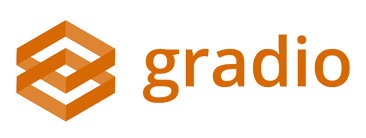

In [8]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown('''
            # Multimodal video search using CLIP and LanceDB
            We used LanceDB to store frames every thirty seconds and the title of 13000+ videos, 5 random from each top category from the Youtube 8M dataset.
            Then, we used the CLIP model to embed frames and titles together. With LanceDB, we can perform embedding, keyword, and SQL search on these videos.
            ''')
    with gr.Row():
        with gr.Tab("Embeddings"):
            vector_query = gr.Textbox(value="retro gaming", show_label=False)
            b1 = gr.Button("Submit")
        with gr.Tab("Keywords"):
            keyword_query = gr.Textbox(value="ninja turtles", show_label=False)
            b2 = gr.Button("Submit")
        with gr.Tab("SQL"):
            sql_query = gr.Textbox(value="SELECT DISTINCT video_id, * from videos WHERE start_time > 0 LIMIT 9", show_label=False)
            b3 = gr.Button("Submit")
    with gr.Row():
        code = gr.Code(label="Code", language="python")
    with gr.Row():
        gallery = gr.HTML()

    b1.click(find_video_vectors, inputs=vector_query, outputs=[gallery, code])
    b2.click(find_video_keywords, inputs=keyword_query, outputs=[gallery, code])
    b3.click(find_video_sql, inputs=sql_query, outputs=[gallery, code])

demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0662a5afdeff28d760.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
